# sim dataset

Model: ResLogit Model, 1-layer, 16 hidden units

We import the dataset into the `cmt.Database()` class and indicate the choice column in the argument `choiceVar`.

In [1]:
import os
import pandas as pd
import pycmtensor as cmt
cmt.__version__

'0.7.0'

In [2]:
import os
import pandas as pd

# read csv file and set columns to UPPERCASE
nb_path = os.path.abspath("")
model_average_sim = pd.read_csv("../../data/model_average_sim.csv")
model_average_sim.columns = model_average_sim.columns.str.upper()

# load database
db = cmt.Database("model_average_sim", model_average_sim, choiceVar="CHOICE")
globals().update(db.variables)

## Data preparation
We perform some data cleaning and setting the choices to start from index 0.

In [3]:
# additional steps to format database
db.data["CHOICE"] -= 1
time_columns = ["CAR_TIME", "AIR_TIME", "AIR_ACCESS", "RAIL_TIME", "RAIL_ACCESS", "HSR_TIME", "HSR_ACCESS"]
cost_columns = ["CAR_COST", "AIR_COST", "RAIL_COST", "HSR_COST"]
income_columns = ["INCOME"]
db.autoscale(variables=time_columns, default=60., verbose=True)
db.autoscale(variables=cost_columns, default=100., verbose=True)
db.autoscale(variables=income_columns, default=1000., verbose=True)

## Model specification
from the `pycmtensor` library, we import two classes to help us define the betas and (neural network) weights.

In [4]:
from pycmtensor.expressions import Beta, Weights
from pycmtensor import aet

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_access = Beta("b_access", 0.0, None, None, 0)
b_income_rail = Beta("b_income_rail", 0.0, None, None, 0)
b_income_hsr = Beta("b_income_hsr", 0.0, None, None, 0)
b_income_car = Beta("b_income_car", 0.0, None, None, 0)
b_female_car = Beta("b_female_car", 0.0, None, None, 0)
b_female_rail = Beta("b_female_rail", 0.0, None, None, 0)
b_female_air = Beta("b_female_air", 0.0, None, None, 0)

asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_air = Beta("asc_air", 0.0, None, None, 0)
asc_rail = Beta("asc_rail", 0.0, None, None, 0)
asc_hsr = Beta("asc_hsr", 0.0, None, None, 1)

# specify weight parameters
W1 = Weights("ResNet_01a", (4, 16), 0, True)
W2 = Weights("ResNet_01b", (16, 4), 0, True)

We specify the utility functions for the four choices respectively as `U_car`, `U_air`, `U_rail`, and `U_hsr`.

In [5]:
U_car = (
    b_cost * db["CAR_COST"]
    + b_time * db["CAR_TIME"]
    + b_income_car * db["INCOME"]
    + b_female_car * db["FEMALE"]
    + asc_car
)
U_air = (
    b_cost * db["AIR_COST"]
    + b_time * db["AIR_TIME"]
    + b_access * db["AIR_ACCESS"]
    + b_female_air * db["FEMALE"]
    + asc_air
)
U_rail = (
    b_cost * db["RAIL_COST"]
    + b_time * db["RAIL_TIME"]
    + b_access * db["RAIL_ACCESS"]
    + b_income_rail * db["INCOME"]
    + b_female_rail * db["FEMALE"]
    + asc_rail
)
U_hsr = (
    b_cost * db["HSR_COST"]
    + b_time * db["HSR_TIME"]
    + b_access * db["HSR_ACCESS"]
    + b_income_hsr * db["INCOME"]
    + asc_hsr
)

# Associate utility functions with the list
U = [U_car, U_air, U_rail, U_hsr]

Here we apply the ResLogit structure to our utility functions. `W1` and `W2` are the input and output weights of the residual layer.

In [6]:
import dill as pickle
from pycmtensor.models import MNLogit, ResLogitLayer
from pycmtensor.optimizers import Adam
from pycmtensor.results import Results

# generate the output from the ResLogit Layer
U = ResLogitLayer(U, W1, W2).output

## Estimation
The main estimation algorithm is as follows. We apply the Adam optimization algorithm and use a batch size of 128 samples. A cyclic learning rate is applied to the training process.

In [7]:
model = MNLogit(U, av=None, database=db, name="sim_model")
model.add_params(locals())
model.config["debug"] = True
model.config["patience"] = 20000
model.config["max_epoch"] = 500
model.config["batch_size"] = 128
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.01
model.config["learning_scheduler"] = "CyclicLR"
model.config["cyclic_lr_step_size"] = 8

# train function
model = cmt.train(model, database=db, optimizer=Adam, notebook=True)

[2022-03-22 14:33:57] WARNING: max_epoch=500 is smaller than expected value =645, setting default max_epoch=645.
  11 log likelihood -3779.09 | score 0.62 | learning rate 8.13e-03
  24 log likelihood -3718.15 | score 0.62 | learning rate 7.50e-03
  35 log likelihood -3709.65 | score 0.62 | learning rate 5.47e-03
  50 log likelihood -3707.59 | score 0.62 | learning rate 5.16e-03
  70 log likelihood -3705.86 | score 0.62 | learning rate 5.23e-03
  94 log likelihood -3705.52 | score 0.62 | learning rate 5.04e-03
 106 log likelihood -3704.14 | score 0.62 | learning rate 5.06e-03
 133 log likelihood -3703.13 | score 0.62 | learning rate 5.01e-03
 152 log likelihood -3703.12 | score 0.62 | learning rate 5.01e-03
 169 log likelihood -3702.35 | score 0.62 | learning rate 5.00e-03
 190 log likelihood -3701.47 | score 0.62 | learning rate 5.00e-03
 205 log likelihood -3700.30 | score 0.62 | learning rate 5.00e-03
 220 log likelihood -3699.26 | score 0.62 | learning rate 5.00e-03
 235 log likelih

Optimization complete with accuracy of 62.300%. Max loglikelihood reached @ epoch 594.



## Results
The results of the model are printed by calling the `Results` class on the estimated model.

In [8]:
result = Results(model, db)
result.print_beta_statistics()
result.print_correlation_matrix()

Results for model: sim_model
Build time: 00:00:18
Estimation time: 00:00:19
Estimation rate: 1040.492 iter/s
Seed value: 1611
Number of Beta parameters: 12
Tensor size: 128
Sample size: 4000
Excluded data: 0
Init loglikelihood: -5507.089
Final loglikelihood: -3688.337
Final loglikelihood reached at: epoch 594
Likelihood ratio test: 3637.504
Accuracy: 62.300%
Rho square: 0.330
Rho bar square: 0.305
Akaike Information Criterion: 7656.67
Bayesian Information Criterion: 8537.84
Final gradient norm: 0.065

Statistical Analysis:
                  Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_air       -0.782345  0.154686  -5.057621       0.0      0.09742   -8.030626          0.0
asc_car        0.663012  0.181727   3.648401  0.000264     0.003733   177.59895          0.0
asc_rail      -0.551805  0.259656  -2.125141  0.033575     0.072251   -7.637384          0.0
b_access       -0.36849  0.087024  -4.234331  0.000023     0.001196 -308.008285          0.0
b_cost

Optionally, we can plot the estimation performance vs. the number of iterations. Note that the x-axis is on a log-scale.

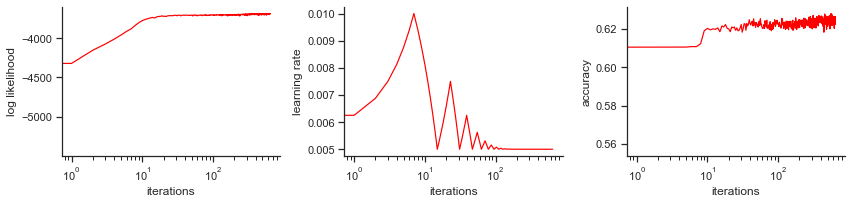

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()

## Output choice probabilities
To generate the probability outputs, we call the `Predict` class on the model `model` and the database `db`. Two methods are used: `probs()` to generate the probabilities and `choices()` to generate a pseudo-choice output by selecting the choice with the highest probability. The code below concatenates the probabilities and choices together.

In [17]:
from pycmtensor.results import Predict

Predict(model, db).probs().to_csv("prob_sim.csv", header=['1', '2', '3', '4'])
Predict(model, db).probs()

,0,1,2,3
0,0.588326,0.059794,0.075032,0.276848
1,0.815734,0.046918,0.026353,0.110996
2,0.488972,0.192655,0.071940,0.246433
3,0.803425,0.082208,0.029795,0.084572
4,0.442764,0.505007,0.028374,0.023855
...,...,...,...,...
3995,0.765334,0.061932,0.072377,0.100357
3996,0.373464,0.045757,0.032746,0.548032
3997,0.834153,0.045449,0.045774,0.074625
3998,0.697534,0.060855,0.035895,0.205717


## Elasticites
We can calculate the elasticities from the model too.

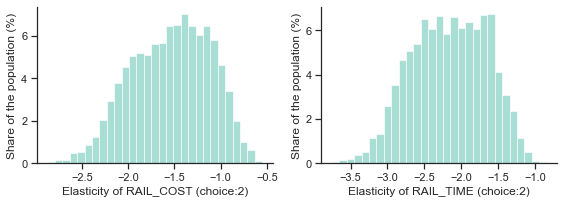

In [13]:
from pycmtensor.statistics import elasticities
els_1 = elasticities(model, db, prob_choice=2, wrt="RAIL_COST")
els_2 = elasticities(model, db, prob_choice=2, wrt="RAIL_TIME")
fig, axs = plt.subplots(1, 2, figsize=(8, 3), squeeze=False)
e1 = sns.histplot(els_1, ax=axs[0, 0], stat="percent")
e2 = sns.histplot(els_2, ax=axs[0, 1], stat="percent")
e1.set(xlabel="Elasticity of RAIL_COST (choice:2)", ylabel="Share of the population (%)")
e2.set(xlabel="Elasticity of RAIL_TIME (choice:2)", ylabel="Share of the population (%)")
sns.despine()
plt.tight_layout()
plt.show()